### HW2 Code Q7

### Part A

In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

In [17]:
# -----------
# Graded Cell
# -----------
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values

    Because the argmax fuunction returns the first instace of the highest value,
    this is why we need to record all top value index and randomly choice one
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = []
        if q_values[i] == top_value:
            ties.append(i)
        
    return np.random.choice(ties)

In [18]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"
print(argmax(test_array))

8


In [19]:
# make sure np.random.choice is called correctly
np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0
print(argmax(test_array))

3


In [40]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        # for previous action
        # update N(A)
        self.arm_count[self.last_action] += 1

        # Update Q(A)
        self.q_values[self.last_action] = self.q_values[self.last_action] + (1/self.arm_count[self.last_action])*(reward - self.q_values[self.last_action])

        # select new action
        self.last_action = argmax(self.q_values)

        return self.last_action
    

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 123.37it/s]


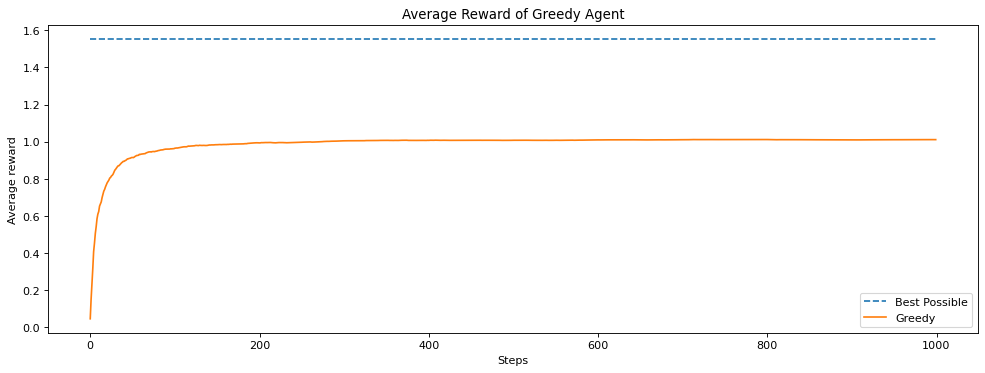

In [41]:
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

### Part B

In [52]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        # for previous action
        # update N(A)
        self.arm_count[self.last_action] += 1

        # Update Q(A)
        self.q_values[self.last_action] = self.q_values[self.last_action] + (1/self.arm_count[self.last_action])*(reward - self.q_values[self.last_action])        
        
        # choose new action
        if np.random.random() < self.epsilon: # np.random.random() is default [0, 1]
            self.last_action = np.random.randint(0, len(self.q_values))
        else:
            self.last_action = argmax(self.q_values)
        
        return self.last_action
    

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 155.12it/s]


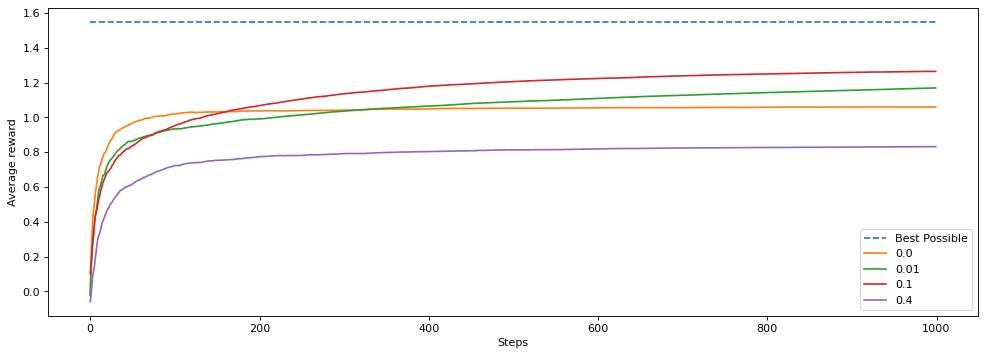

In [53]:
# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

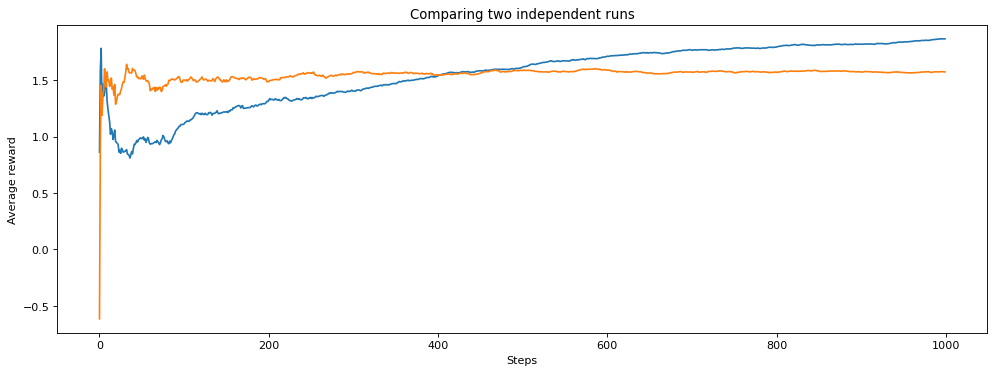

In [54]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

### Part C

In [55]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        # for previous action
        # update N(A)
        self.arm_count[self.last_action] += 1

        # Update Q(A)
        self.q_values[self.last_action] = self.q_values[self.last_action] + (self.step_size)*(reward - self.q_values[self.last_action])        
        
        # choose new action
        if np.random.random() < self.epsilon: # np.random.random() is default [0, 1]
            self.last_action = np.random.randint(0, len(self.q_values))
        else:
            self.last_action = argmax(self.q_values)
        
        return self.last_action

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 122.65it/s]
/tmp/ipykernel_9060/2012287133.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


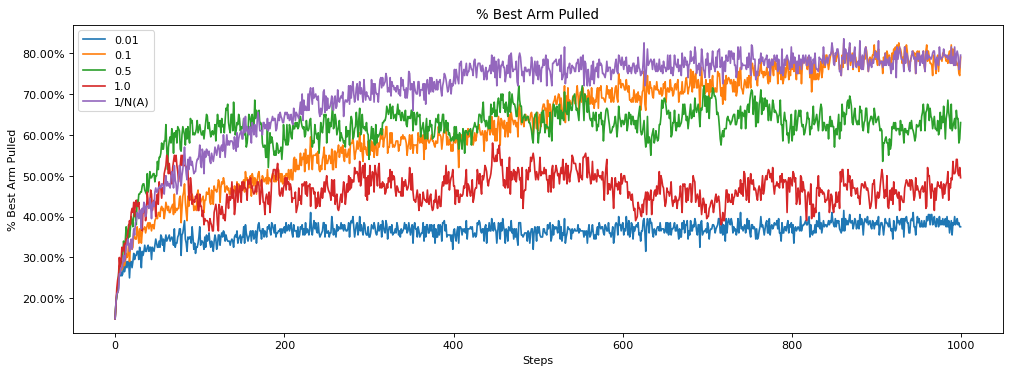

In [56]:
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

### Part D

In [73]:
class UCBAgent(main_agent.Agent):
    def __init__(self):
        super().__init__()
        self.total_count = 0  # Total number of steps/actions taken
        self.c = 2  # coefficient of UCB
        
    def agent_step(self, reward, observation=None):
        # for previous action
        # update N(A)
        self.arm_count[self.last_action] += 1
        self.total_count += 1

        # Update Q(A)
        self.q_values[self.last_action] = self.q_values[self.last_action] + (1/self.arm_count[self.last_action])*(reward - self.q_values[self.last_action])

        # select new action
        self.last_action = argmax(self.q_values + self.c* np.sqrt(np.log(self.total_count) / (self.arm_count + 1e-5)) )

        return self.last_action

In [76]:
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = UCBAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

  0%|                                                   | 0/200 [00:00<?, ?it/s]


TypeError: can only concatenate list (not "float") to list

In [4]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards



def figure(runs=200, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)

    plt.plot(average_rewards[0], label='UCB $c = 2$')
    plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.savefig('figure.png')
    plt.close()



if __name__ == '__main__':
    figure()